In [3]:
# Brain Tumor Detection Using CNN

#This notebook implements a convolutional neural network (CNN) for detecting brain tumors using MRI images. The model is trained on a dataset of brain MRI scans.



In [4]:
# Import Libraries
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras import layers, models, regularizers, callbacks
from tensorflow.keras.optimizers import Adam


In [7]:
# Paths to the dataset directories
base_dir = r'C:\Users\Binny\Desktop\mri\brain_mri'
yes_dir = os.path.join(base_dir, 'yes')
no_dir = os.path.join(base_dir, 'no')

# Load image paths and labels
yes_images = [os.path.join(yes_dir, img) for img in os.listdir(yes_dir)]
no_images = [os.path.join(no_dir, img) for img in os.listdir(no_dir)]
all_images = yes_images + no_images
labels = [1] * len(yes_images) + [0] * len(no_images)

# Convert lists to NumPy arrays
all_images = np.array(all_images)
labels = np.array(labels)


In [8]:
# Split the dataset into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(
    all_images, labels, test_size=0.2, random_state=42, stratify=labels)


In [10]:
# Data generators with augmentation for training and simple rescaling for validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)


In [11]:
# Load images using a generator
def load_images(image_paths, labels, batch_size, target_size=(231, 283)):
    num_samples = len(image_paths)
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_images = image_paths[offset:offset + batch_size]
            batch_labels = labels[offset:offset + batch_size]
            images = [img_to_array(load_img(img, target_size=target_size)) / 255.0 for img in batch_images]
            yield np.array(images), np.array(batch_labels)

train_steps = np.ceil(len(train_images) / 32).astype(int)
val_steps = np.ceil(len(val_images) / 32).astype(int)


In [12]:
# Define the model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(231, 283, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),
    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])


c:\Users\Binny\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
# Compile the model
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [15]:
# Early stopping callback
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [16]:
# Train the model with Early Stopping
history = model.fit(
    load_images(train_images, train_labels, batch_size=32),
    steps_per_epoch=train_steps,
    epochs=13,
    validation_data=load_images(val_images, val_labels, batch_size=32),
    validation_steps=val_steps,
    callbacks=[early_stopping]
)


Epoch 1/13
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 805ms/step - accuracy: 0.6477 - loss: 4.6935 - val_accuracy: 0.7647 - val_loss: 3.5737
Epoch 2/13
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 781ms/step - accuracy: 0.6533 - loss: 3.5011 - val_accuracy: 0.7451 - val_loss: 3.1679
Epoch 3/13
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.7523 - loss: 3.0051 - val_accuracy: 0.7647 - val_loss: 2.8402
Epoch 4/13
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 917ms/step - accuracy: 0.7696 - loss: 2.6876 - val_accuracy: 0.7451 - val_loss: 2.5169
Epoch 5/13
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.7243 - loss: 2.4073 - val_accuracy: 0.8039 - val_loss: 2.2466
Epoch 6/13
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 771ms/step - accuracy: 0.7780 - loss: 2.1289 - val_accuracy: 0.7843 - val_loss: 2.0470
Epoch 7/13
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 742ms/step - accuracy: 0.7571 - loss: 1.9517 - val_accuracy: 0.8235 - val_loss: 1.8903
Epoch 8/13
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 739ms/step - accuracy: 0.7700 - loss: 1.7767 - val_accuracy: 0.8431 - val_loss: 1.7

In [17]:
# Save the trained model
model.save('my_model.keras')


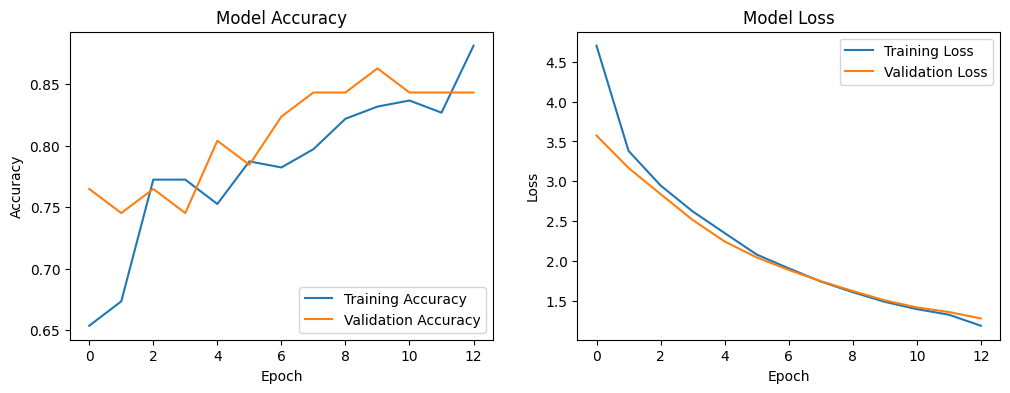

In [18]:
# Plot accuracy and loss over epochs
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()


In [19]:
# Evaluate the model on the validation set
eval_result = model.evaluate(load_images(val_images, val_labels, batch_size=32), steps=val_steps)
print(f"\nFinal Validation Loss: {eval_result[0]:.4f}")
print(f"Final Validation Accuracy: {eval_result[1]:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.8329 - loss: 1.2970

Final Validation Loss: 1.2820
Final Validation Accuracy: 0.8431


In [20]:
# Predict labels for the validation set
predictions = model.predict(load_images(val_images, val_labels, batch_size=32), steps=val_steps)
predictions = np.round(predictions).astype(int).flatten()

# Confusion Matrix
conf_matrix = confusion_matrix(val_labels[:len(predictions)], predictions)
print("\nConfusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(val_labels[:len(predictions)], predictions, target_names=['No Tumor', 'Tumor'])
print("\nClassification Report:")
print(class_report)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step

Confusion Matrix:
[[12  8]
 [ 0 31]]

Classification Report:
              precision    recall  f1-score   support

    No Tumor       1.00      0.60      0.75        20
       Tumor       0.79      1.00      0.89        31

    accuracy                           0.84        51
   macro avg       0.90      0.80      0.82        51
weighted avg       0.88      0.84      0.83        51



In [21]:
# Model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 229, 281, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 114, 140, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 114, 140, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 138, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 69, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 69, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 54, 67, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 27, 33, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 114048)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,598,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,074,949 (168.13 MB)

 Trainable params: 14,691,649 (56.04 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 29,383,300 (112.09 MB)